In [1]:
import zipfile
import os

# Path to the zip file
zip_path = r'C:\Users\Aditya Agarwal\OneDrive\Desktop\Semester\Semester-5\Digital Image Processing\emotion\emotion\face_emotion.zip'

# Directory where you want to unzip the file
extract_path = r'C:\Users\Aditya Agarwal\OneDrive\Desktop\Semester\Semester-5\Digital Image Processing\emotion'

# Unzipping
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")


Unzipped successfully!


In [2]:
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
facialexpression_df = pd.read_csv('face_emotion/icml_face_data.csv')
facialexpression_df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
train_df = pd.read_csv("face_emotion/train.csv")
train_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
train_df.shape

(28709, 2)

In [6]:
(train_df.emotion.value_counts() / len(train_df)).to_frame().sort_index().T

emotion,0,1,2,3,4,5,6
count,0.139155,0.015187,0.142708,0.251315,0.16824,0.110453,0.172942


In [7]:
df_test= pd.read_csv("face_emotion/test.csv")
df_test.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [8]:
df_test.shape

(7178, 1)

In [9]:
print(facialexpression_df.columns.tolist())

['emotion', ' Usage', ' pixels']


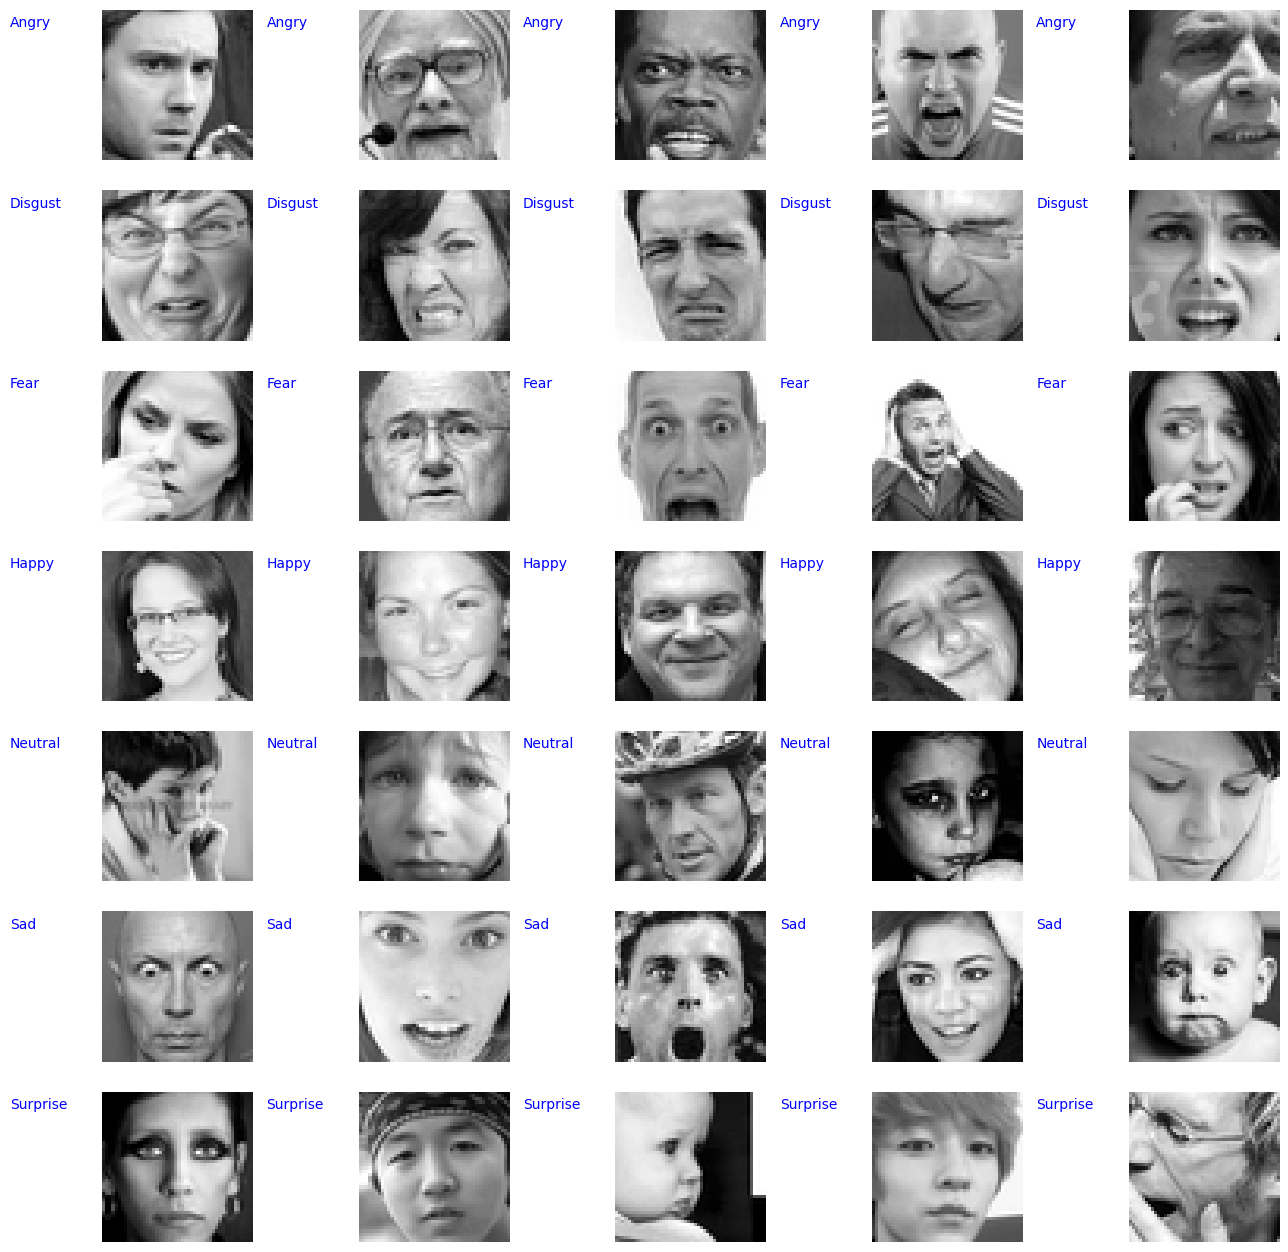

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming emotions is a dictionary mapping emotion labels to integers
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}


plt.close()
plt.rcParams["figure.figsize"] = [16, 16]

row = 0
for emotion in np.unique(train_df['emotion']):
    all_emotion_images = train_df[train_df['emotion'] == emotion]
    for i in range(5):
        # Convert the pixel values from string to list of integers
        pixel_values = list(map(int, all_emotion_images.iloc[i]['pixels'].split()))
        # Convert the list of integers to a numpy array and reshape it into a 2D array
        img = np.array(pixel_values).reshape(48, 48)
        lab = emotions[emotion]

        plt.subplot(7, 5, row + i + 1)
        plt.imshow(img, cmap='binary_r')
        plt.text(-30, 5, s=str(lab), fontsize=10, color='b')
        plt.axis('off')
    row += 5

plt.show()


In [11]:
facialexpression_df[' pixels'][0] # String format

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [12]:
facialexpression_df.isnull().sum()

emotion    0
 Usage     0
 pixels    0
dtype: int64

In [13]:
label_to_text = {0:'angry', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sad', 5: 'surprise', 6: 'neutral'}

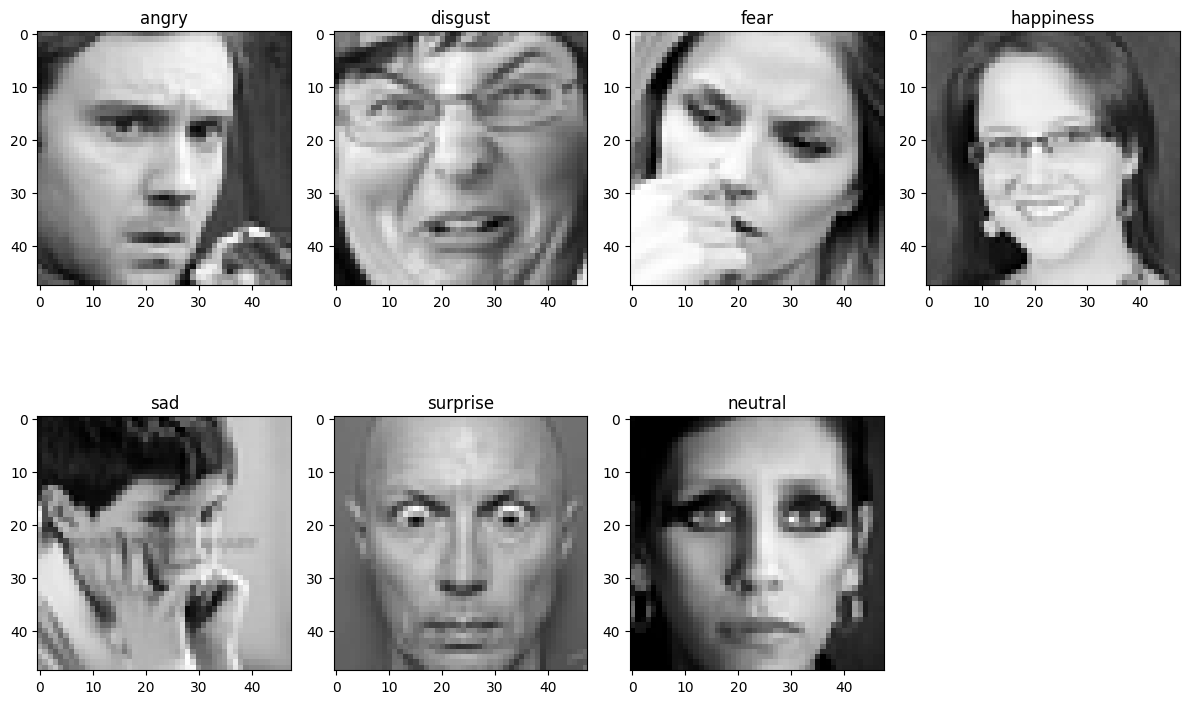

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'pixels' column contains strings of pixel values separated by space
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: np.fromstring(x, sep=' ', dtype=int))

num_rows = 2
num_cols = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axes = axes.flatten()

emotions = [0, 1, 2, 3, 4, 5, 6]

for i in emotions:
    data = facialexpression_df[facialexpression_df['emotion'] == i][:1]
    img_pixels = data[' pixels'].values[0]  # Extract pixel values from the DataFrame
    img = img_pixels.reshape(48, 48)
    ax = axes[i]
    ax.set_title(label_to_text[i])
    ax.imshow(img, cmap='gray')

for i in range(len(emotions), num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [15]:
facialexpression_df.emotion.value_counts().index

Index([3, 6, 4, 2, 0, 5, 1], dtype='int64', name='emotion')

In [16]:
facialexpression_df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

{0:'angry', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sad', 5: 'surprise', 6: 'neutral'}

<Axes: xlabel='emotion', ylabel='count'>

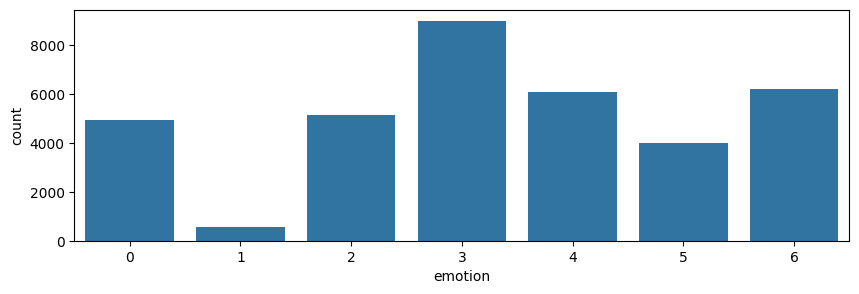

In [17]:
plt.figure(figsize = (10,3))
sns.barplot(x = facialexpression_df.emotion.value_counts().index, y = facialexpression_df.emotion.value_counts())

In [18]:
# Separate data based on 'Usage' column
train_data = facialexpression_df[facialexpression_df[' Usage'] == 'Training']
test_data = facialexpression_df[facialexpression_df[' Usage'] == 'PublicTest']
val_data = facialexpression_df[facialexpression_df[' Usage'] == 'PrivateTest']

#Training Data
X_train = train_data[' pixels']
y_train = train_data['emotion']

#Testing Data
X_test = test_data[' pixels']
y_test = test_data['emotion']

#Validation Data
X_val = val_data[' pixels']
y_val = val_data['emotion']

In [19]:
X_train = train_data[' pixels']
y_train = to_categorical(train_data['emotion'])

X_test = test_data[' pixels']
y_test = to_categorical(test_data['emotion'])

X_val = val_data[' pixels']
y_val = to_categorical(val_data['emotion'])

In [20]:
X_train = np.stack(X_train, axis = 0)
X_train = X_train.reshape(28709 , 48, 48, 1)

X_test = np.stack(X_test, axis = 0)
X_test = X_test.reshape(3589 , 48, 48, 1)

X_val = np.stack(X_val, axis = 0)
X_val = X_val.reshape(3589 , 48, 48, 1)

In [21]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(28709, 48, 48, 1) (28709, 7)
(3589, 48, 48, 1) (3589, 7)
(3589, 48, 48, 1) (3589, 7)


In [22]:
# image pre-processing

X_train = X_train/255
X_val   = X_val /255
X_Test  = X_test/255

# Data Argumentation

In [23]:
train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest")

In [27]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Add, ZeroPadding2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model

# BUILD DEEP RESIDUAL NEURAL NETWORK FOR FACIAL POINTS DETECTION MODEL
def res_block(X, filters, stage):
    f1, f2, f3 = filters
    
    # Convolutional_block
    # Main Path
    X_shortcut = X  # Save the input value
    
    # First Conv layer
    X = Conv2D(f1, (1,1), strides=(1,1))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Second Conv layer
    X = Conv2D(f2, kernel_size=(3,3), strides=(1,1), padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Third Conv layer
    X = Conv2D(f3, kernel_size=(1,1), strides=(1,1))(X)
    X = BatchNormalization()(X)
    
    # Short path
    X_shortcut = Conv2D(f3, kernel_size=(1,1), strides=(1,1))(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    
    # Add shortcut value to main path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

# Input shape
input_shape = (48, 48, 1)
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# Stage 1
X = Conv2D(64, (7, 7), strides=(2, 2))(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides=(2, 2))(X)

# Stage 2
X = res_block(X, filters=[64, 64, 256], stage=2)

# Stage 3
X = res_block(X, filters=[128, 128, 512], stage=3)

# Average Pooling
X = AveragePooling2D((2, 2), name='Average_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(7, activation='softmax', name='Dense_final', kernel_initializer=glorot_uniform(seed=0))(X)

# Create model
model_emotion = Model(inputs=X_input, outputs=X, name='Resnet18')

# Model summary
model_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 54, 54, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 24, 24, 64)   3200        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 24, 24, 64)   256         conv2d_10[0][0]                  
___________________________________________________________________________________________

Softmax Activation Function:

In neural networks for multi-class classification, the softmax activation function is often used in the output layer.
Softmax converts the raw model outputs into a probability distribution, and the predicted probabilities are then used in the cross-entropy loss calculation.

Cross-entropy is a loss function commonly used in machine learning, and specifically in the training of classification models, including neural networks. It quantifies the difference between the predicted probability distributions and the true distribution of the labels.

Measuring Information Gain:

Cross-entropy originates from information theory and is used to measure the difference between two probability distributions.
In classification, one distribution represents the true labels (ground truth), and the other represents the predicted probabilities assigned by the model.
Categorical Cross-Entropy for Multi-Class Classification:

In multi-class classification problems, where each sample can belong to one of several classes, categorical cross-entropy is commonly used as the loss function.
It's suitable when the classes are mutually exclusive (each sample belongs to exactly one class).

In [28]:
# train the network
model_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [29]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20)
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "Emotion.hdf5", save_best_only=True)

In [30]:
history = model_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
	epochs= 10, callbacks=[checkpointer, earlystopping])

Epoch 1/10
448/448 [==============================] - 13s 12ms/step - loss: 1.8044 - accuracy: 0.3354 - val_loss: 1.7482 - val_accuracy: 0.2956
Epoch 2/10
 11/448 [..............................] - ETA: 4s - loss: 1.5813 - accuracy: 0.3864

c:\Users\sayantan\anaconda3\envs\new\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


448/448 [==============================] - 5s 11ms/step - loss: 1.4725 - accuracy: 0.4325 - val_loss: 1.4773 - val_accuracy: 0.4221
Epoch 3/10
448/448 [==============================] - 5s 11ms/step - loss: 1.3700 - accuracy: 0.4784 - val_loss: 1.6979 - val_accuracy: 0.3402
Epoch 4/10
448/448 [==============================] - 5s 11ms/step - loss: 1.3046 - accuracy: 0.5045 - val_loss: 1.2645 - val_accuracy: 0.5127
Epoch 5/10
448/448 [==============================] - 5s 11ms/step - loss: 1.2556 - accuracy: 0.5208 - val_loss: 1.3332 - val_accuracy: 0.4915
Epoch 6/10
448/448 [==============================] - 5s 11ms/step - loss: 1.2130 - accuracy: 0.5420 - val_loss: 1.2829 - val_accuracy: 0.5230
Epoch 7/10
448/448 [==============================] - 5s 11ms/step - loss: 1.1895 - accuracy: 0.5504 - val_loss: 1.2169 - val_accuracy: 0.5430
Epoch 8/10
448/448 [==============================] - 5s 11ms/step - loss: 1.1624 - accuracy: 0.5635 - val_loss: 1.1556 - val_accuracy: 0.5528
Epoch 9/10

In [31]:
score = model_emotion.evaluate(X_Test, y_test)
print('Test Accuracy: {}'.format(score[1]))

113/113 [==============================] - 0s 4ms/step - loss: 1.1975 - accuracy: 0.5461
Test Accuracy: 0.546113133430481


#Set Balanced Dataset with Equal Class Counts

##Creating a balanced dataset with equal class counts is a crucial preprocessing step in machine learning to ensure fair and unbiased model training. This process involves equalizing the number of instances across different classes, preventing the model from being skewed towards the majority class. A balanced dataset fosters better generalization and improved performance, particularly in scenarios where class imbalances could lead to biased predictions.

In [35]:
from sklearn.utils import resample

# Calculate the average class count
average_class_count = facialexpression_df['emotion'].value_counts().mean()

# Separate data for each class
class_data = [facialexpression_df[facialexpression_df['emotion'] == i] for i in range(7)]

# Oversample to balance classes based on average class count
oversampled_data = [resample(class_df, replace=True, n_samples=int(average_class_count), random_state=42) for class_df in class_data]
balanced_data = pd.concat(oversampled_data)

In [36]:
balanced_data.head()

,emotion,Usage,pixels
5947,0,Training,"[2, 5, 31, 37, 18, 42, 57, 68, 80, 96, 108, 12..."
27250,0,Training,"[76, 80, 82, 104, 122, 121, 114, 117, 123, 122..."
22203,0,Training,"[114, 113, 111, 113, 127, 127, 133, 130, 132, ..."
3227,0,Training,"[131, 137, 136, 134, 141, 140, 140, 143, 141, ..."
31947,0,PublicTest,"[255, 252, 255, 190, 73, 153, 190, 167, 163, 1..."


In [37]:
balanced_data.emotion.value_counts()

emotion
0    5126
1    5126
2    5126
3    5126
4    5126
5    5126
6    5126
Name: count, dtype: int64

<Axes: xlabel='emotion', ylabel='count'>

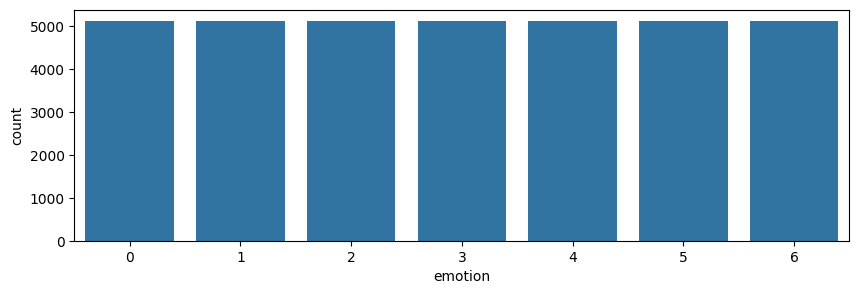

In [38]:
plt.figure(figsize = (10,3))
sns.barplot(x = balanced_data.emotion.value_counts().index, y = balanced_data.emotion.value_counts())

In [39]:
X_train, X_temp, y_train, y_temp = train_test_split(balanced_data[' pixels'], balanced_data['emotion'], test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [40]:
print("Train set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Train set size: 28705
Validation set size: 3588
Test set size: 3589


In [41]:
y_train = to_categorical(y_train)

y_test = to_categorical(y_test)

y_val = to_categorical(y_val)

#DATA PREPARATION AND IMAGE AUGMENTATION

In [42]:
X_train = np.stack(X_train, axis = 0)
X_train = X_train.reshape(28705 , 48, 48, 1)

X_test = np.stack(X_test, axis = 0)
X_test = X_test.reshape(3589 , 48, 48, 1)

X_val = np.stack(X_val, axis = 0)
X_val = X_val.reshape(3588 , 48, 48, 1)

In [43]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(28705, 48, 48, 1) (28705, 7)
(3589, 48, 48, 1) (3589, 7)
(3588, 48, 48, 1) (3588, 7)


In [44]:
X_train = X_train/255
X_val   = X_val /255
X_Test  = X_test/255

In [45]:
model_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [46]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

checkpointer = ModelCheckpoint(filepath = "EmotionExpression.hdf5", verbose = 1, save_best_only=True)

In [47]:
history = model_emotion.fit(X_train, y_train, batch_size=64,
                            validation_data=(X_val, y_val),
                            steps_per_epoch=len(X_train) // 64,
                            epochs=15,
                            callbacks=[checkpointer, earlystopping])

Epoch 1/15
448/448 [==============================] - 4s 7ms/step - loss: 0.9515 - accuracy: 0.6594 - val_loss: 0.8771 - val_accuracy: 0.6948

Epoch 00001: val_loss improved from inf to 0.87711, saving model to EmotionExpression.hdf5
Epoch 2/15


c:\Users\sayantan\anaconda3\envs\new\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


448/448 [==============================] - 3s 7ms/step - loss: 0.6734 - accuracy: 0.7620 - val_loss: 0.7910 - val_accuracy: 0.7271

Epoch 00002: val_loss improved from 0.87711 to 0.79099, saving model to EmotionExpression.hdf5
Epoch 3/15
448/448 [==============================] - 3s 7ms/step - loss: 0.4833 - accuracy: 0.8359 - val_loss: 0.8158 - val_accuracy: 0.7241

Epoch 00003: val_loss did not improve from 0.79099
Epoch 4/15
448/448 [==============================] - 3s 7ms/step - loss: 0.3493 - accuracy: 0.8830 - val_loss: 0.8234 - val_accuracy: 0.7316

Epoch 00004: val_loss did not improve from 0.79099
Epoch 5/15
448/448 [==============================] - 3s 7ms/step - loss: 0.2427 - accuracy: 0.9224 - val_loss: 0.8992 - val_accuracy: 0.7336

Epoch 00005: val_loss did not improve from 0.79099
Epoch 6/15
448/448 [==============================] - 3s 7ms/step - loss: 0.1725 - accuracy: 0.9478 - val_loss: 0.7640 - val_accuracy: 0.7904

Epoch 00006: val_loss improved from 0.79099 to 0

In [48]:
model_json = model_emotion.to_json()
with open("FacialExpression-balanced-model.json","w") as json_file:
  json_file.write(model_json)

In [49]:
 score = model_emotion.evaluate(X_Test, y_test)
print('Test Accuracy: {}'.format(score[1]))

113/113 [==============================] - 1s 4ms/step - loss: 0.9031 - accuracy: 0.8153
Test Accuracy: 0.815268874168396


In [54]:
model_emotion.save('model.h5')

c:\Users\sayantan\anaconda3\envs\new\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [50]:
predicted_classes = np.argmax(model_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

In [51]:
y_true.shape

(3589,)

<Axes: >

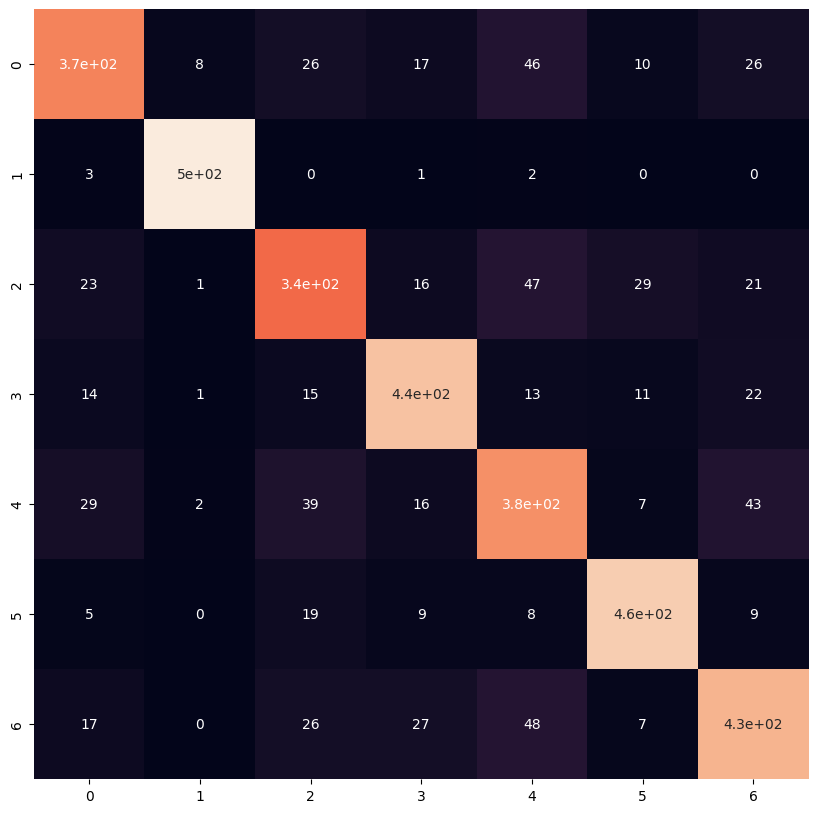

In [52]:
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

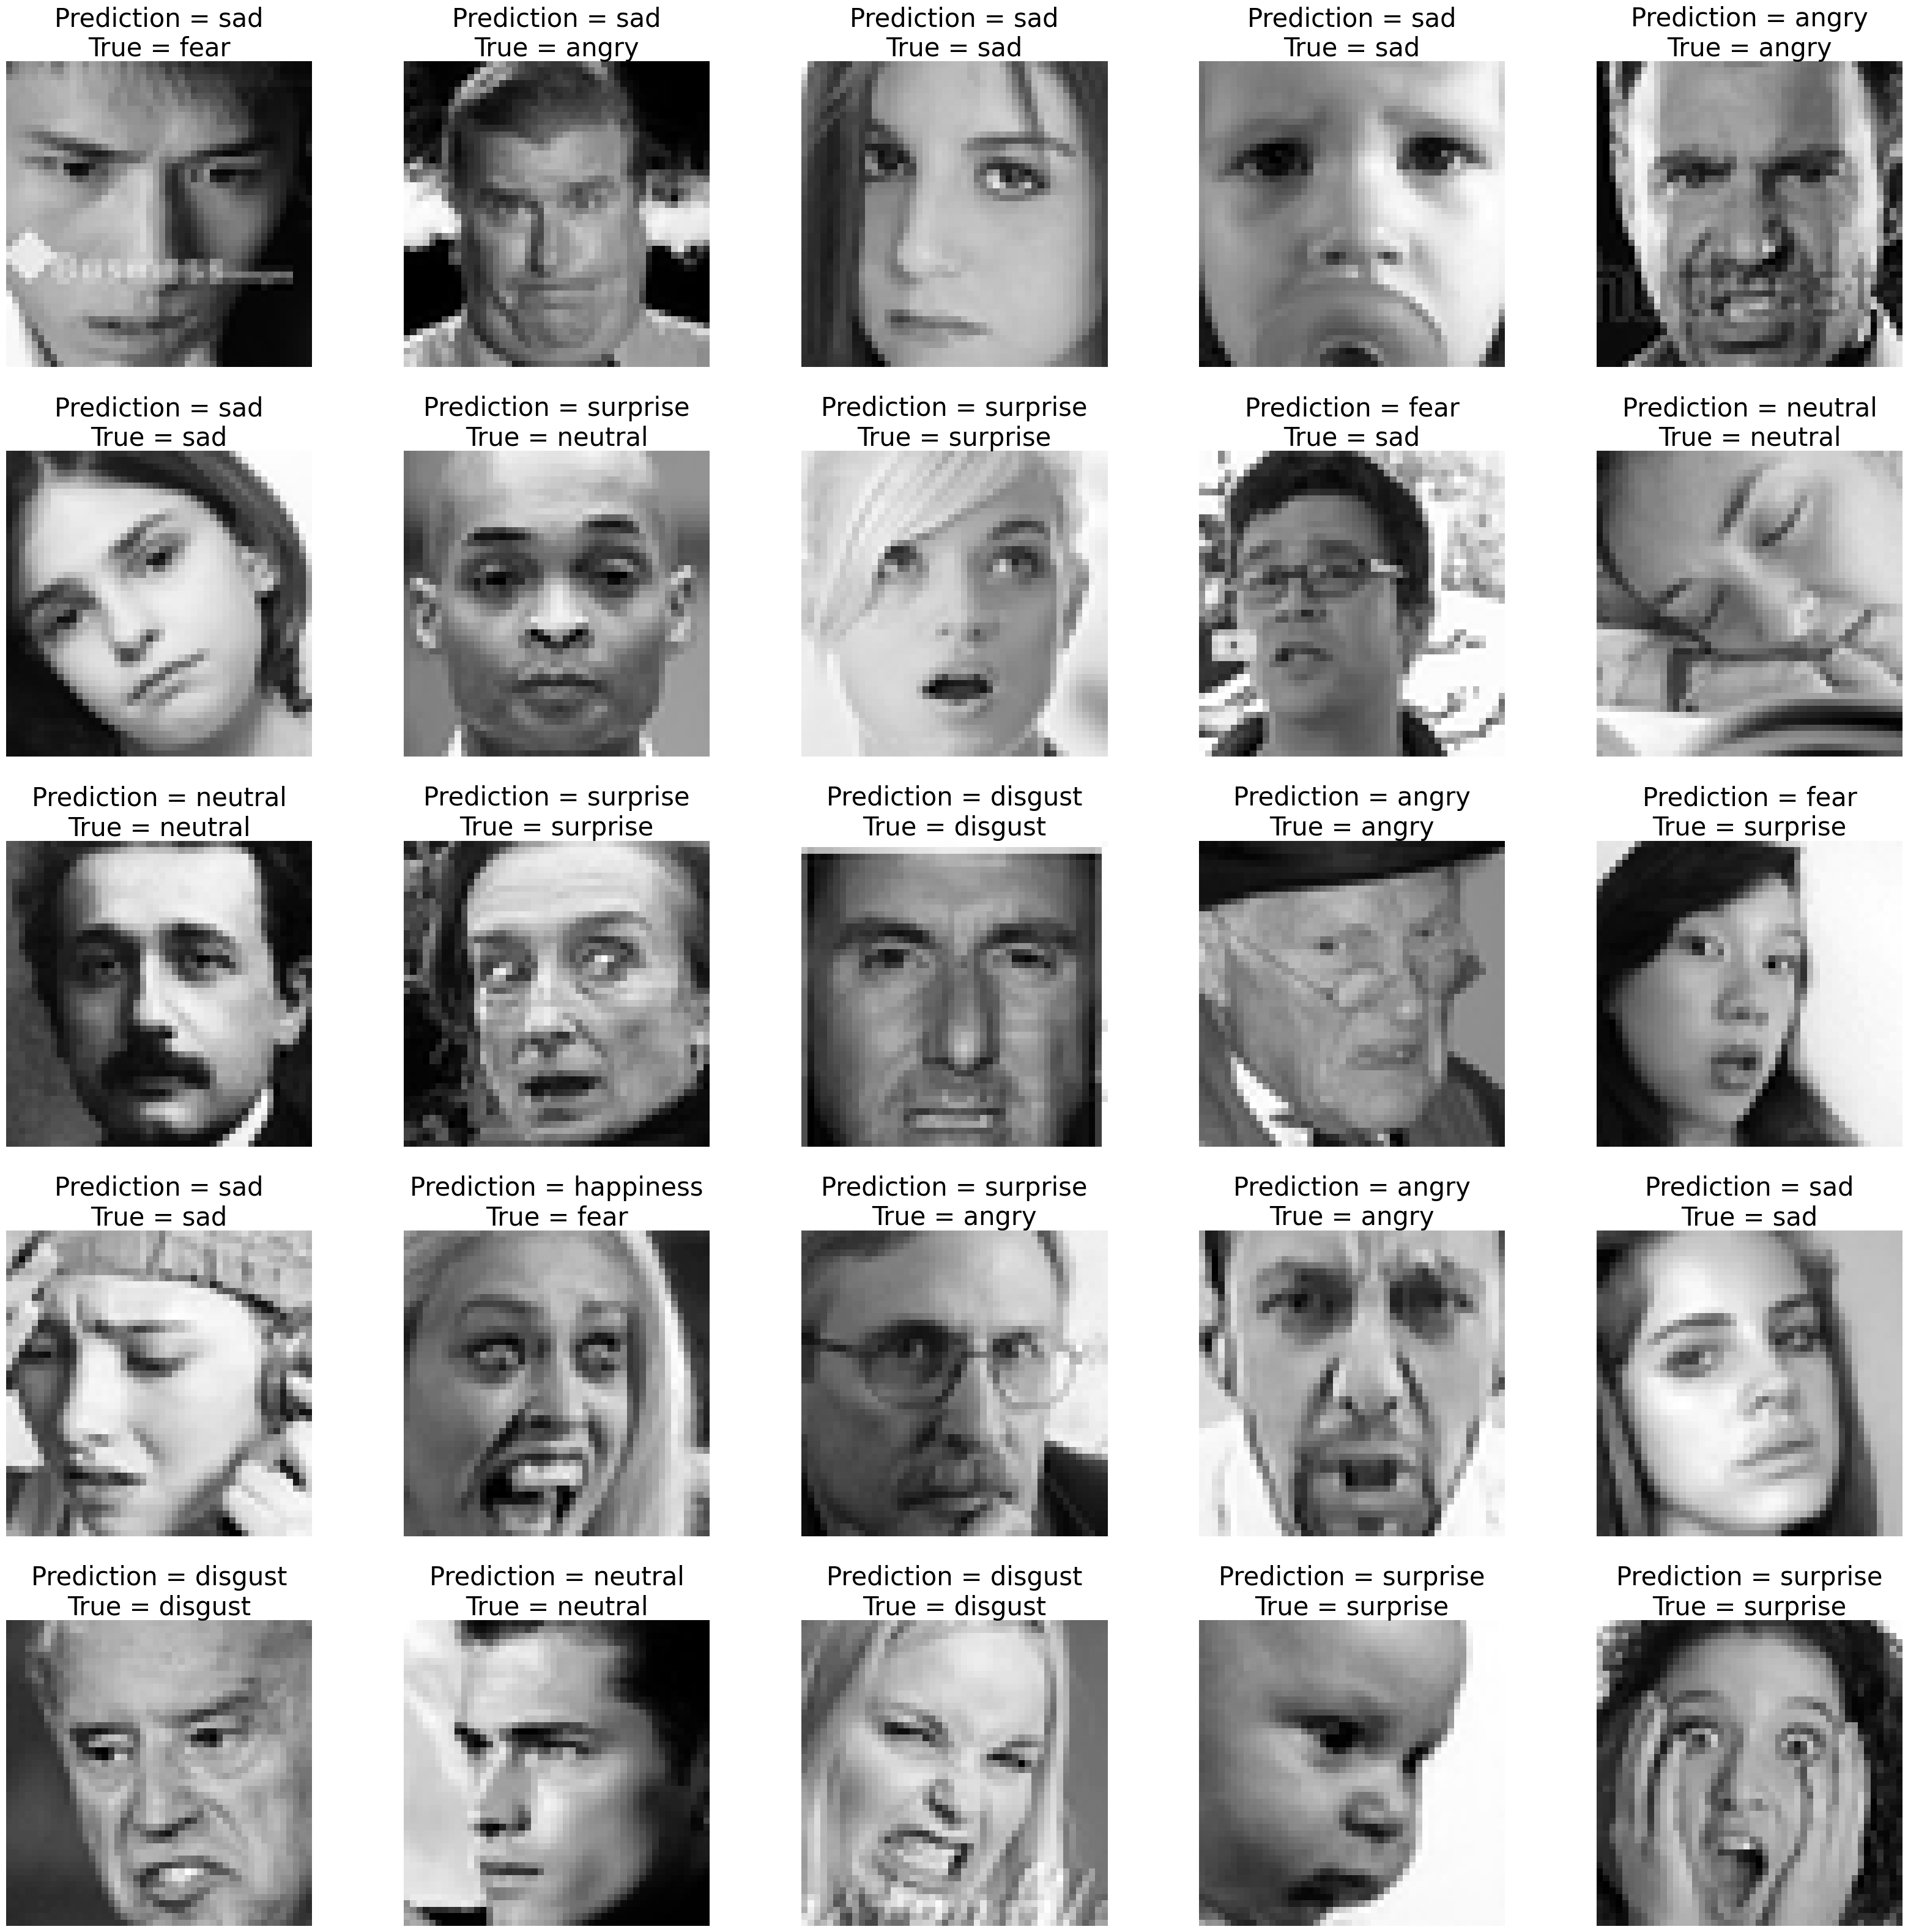

In [53]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize=(40, 40))
axes = axes.ravel()

for i in np.arange(0, L * W):
    axes[i].imshow(X_test[i].reshape(48, 48), cmap='gray')
    title = 'Prediction = {}\nTrue = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]])
    axes[i].set_title(title, fontsize=30)
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.3)
plt.show()

In [5]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

import warnings
import absl.logging

# Ignore all warnings
warnings.filterwarnings("ignore")

# Suppress absl logging warnings
absl.logging.set_verbosity(absl.logging.ERROR)

# Load the saved model
model = load_model(r'C:\Users\Aditya Agarwal\Downloads\dipprojectadityaka\model.h5')

# Function to preprocess the image (resize and convert to grayscale)
def preprocess_image(image):
    # Convert the image to grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the image to 48x48 pixels
    img_resized = cv2.resize(img_gray, (48, 48))

    # Normalize the image and expand dimensions
    img_array = np.array(img_resized, dtype='float32') / 255.0
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension (grayscale)
    img_array = np.expand_dims(img_array, axis=0)   # Add batch dimension

    return img_array

# Emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Start the webcam for real-time emotion classification
print("Starting webcam for real-time emotion classification. Press 'q' to quit.")
cap = cv2.VideoCapture(1)  # Open webcam (use the correct camera index if needed)

while True:
    ret, frame = cap.read()  # Read a frame from the webcam
    if not ret:
        print("Failed to capture frame. Exiting...")
        break

    # Get the region of interest (ROI) for face detection
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        # Extract the face region
        face = frame[y:y + h, x:x + w]

        # Preprocess the face for emotion prediction
        preprocessed_face = preprocess_image(face)

        # Predict emotion
        predicted_emotion = model.predict(preprocessed_face)

        # Get the index of the highest probability
        predicted_class = np.argmax(predicted_emotion, axis=1)
        predicted_label = emotion_labels[predicted_class[0]]

        # Draw a rectangle around the face and display the predicted emotion
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(frame, predicted_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # Display the live frame with predictions
    cv2.imshow("Real-Time Emotion Classification", frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("Exiting...")
        break

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()


Starting webcam for real-time emotion classification. Press 'q' to quit.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Exiting...


In [7]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import warnings
import absl.logging

# Ignore all warnings
warnings.filterwarnings("ignore")
absl.logging.set_verbosity(absl.logging.ERROR)

# Load the saved model
model = load_model(r'C:\Users\Aditya Agarwal\Downloads\dipprojectadityaka\model.h5')

# Define a dictionary for emotions and their corresponding emoji images
emotion_to_emoji = {
    "Angry": r"C:\Users\Aditya Agarwal\Downloads\angryemoji.jpg",
    "Disgust": r"C:\Users\Aditya Agarwal\Downloads\Disgustemoji.jpg",
    "Fear": r"C:\Users\Aditya Agarwal\Downloads\Fearemoji.jpg",
    "Happy": r"C:\Users\Aditya Agarwal\Downloads\happyemoji.jpg",
    "Sad": r"C:\Users\Aditya Agarwal\Downloads\Sademoji.jpg",
    "Surprise": r"C:\Users\Aditya Agarwal\Downloads\Surpriseemoji.jpg",
    "Neutral": r"C:\Users\Aditya Agarwal\Downloads\Neutralemoji.png"
}

# Function to preprocess the image (resize and convert to grayscale)
def preprocess_image(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (48, 48))
    img_array = np.array(img_resized, dtype='float32') / 255.0
    img_array = np.expand_dims(img_array, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Load emojis into a dictionary
def load_emojis():
    emojis = {}
    for emotion, path in emotion_to_emoji.items():
        emojis[emotion] = cv2.imread(path, cv2.IMREAD_UNCHANGED)  # Read with alpha channel
    return emojis

# Overlay an emoji onto the frame
def overlay_emoji(frame, emoji, position):
    x, y, w, h = position
    emoji_resized = cv2.resize(emoji, (w, h))

    # Ensure emoji does not exceed frame boundaries
    frame_h, frame_w = frame.shape[:2]
    h = min(h, frame_h - y)
    w = min(w, frame_w - x)

    for i in range(h):
        for j in range(w):
            if y + i >= frame_h or x + j >= frame_w:
                continue  # Skip out-of-bound positions

            # If the emoji has an alpha channel
            if emoji_resized.shape[2] == 4 and emoji_resized[i, j, 3] > 0:  # Check alpha for transparency
                frame[y + i, x + j] = emoji_resized[i, j, :3]
            # If the emoji does not have an alpha channel
            elif emoji_resized.shape[2] == 3:
                frame[y + i, x + j] = emoji_resized[i, j]
    return frame



# Start the webcam for real-time emotion classification
print("Starting webcam for real-time emotion classification with emojis. Press 'q' to quit.")
cap = cv2.VideoCapture(1)
emotion_labels = list(emotion_to_emoji.keys())
emojis = load_emojis()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame. Exiting...")
        break

    # Detect faces in the frame
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        # Extract the face region
        face = frame[y:y + h, x:x + w]

        # Preprocess the face for emotion prediction
        preprocessed_face = preprocess_image(face)

        # Predict emotion
        predicted_emotion = model.predict(preprocessed_face)
        predicted_class = np.argmax(predicted_emotion, axis=1)
        predicted_label = emotion_labels[predicted_class[0]]

        # Draw a rectangle around the face and display the predicted emotion
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(frame, predicted_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

        # Overlay the corresponding emoji
        if predicted_label in emojis:
            emoji = emojis[predicted_label]
            emoji_size = (x + w + 50, y - 10, 100, 100)  # Define where to place the emoji
            frame = overlay_emoji(frame, emoji,emoji_size)

    # Display the live frame with emojis
    cv2.imshow("Real-Time Emotion Classification with Emoji Overlay", frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("Exiting...")
        break

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()


Starting webcam for real-time emotion classification with emojis. Press 'q' to quit.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/

In [10]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

# Set up matplotlib figure size for inline display (if using Jupyter)
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# Load pre-trained models for age and gender classification
age_model_path = r'C:\Users\Aditya Agarwal\OneDrive\Desktop\Semester\Semester-5\Digital Image Processing\emotion\age_model_pretrained.h5'
gender_model_path = r'C:\Users\Aditya Agarwal\OneDrive\Desktop\Semester\Semester-5\Digital Image Processing\emotion\gender_model_pretrained.h5'

age_model = load_model(age_model_path)
gender_model = load_model(gender_model_path)

# Age and gender ranges
age_ranges = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']
gender_ranges = ['male', 'female']

# Load the face detector from OpenCV (Haar Cascade for face detection)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Initialize the webcam
cap = cv2.VideoCapture(1)

while True:
    # Read frame from webcam
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture image")
        break

    # Convert the frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        # Draw rectangle around detected face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (203, 12, 255), 2)

        # Crop the face from the frame
        face_gray = gray[y:y + h, x:x + w]

        # Resize the face region for gender classification
        gender_img = cv2.resize(face_gray, (100, 100), interpolation=cv2.INTER_AREA)
        gender_image_array = np.array(gender_img)
        gender_input = np.expand_dims(gender_image_array, axis=0)  # Add batch dimension
        output_gender = gender_ranges[np.argmax(gender_model.predict(gender_input))]

        # Resize the face region for age classification
        age_img = cv2.resize(face_gray, (200, 200), interpolation=cv2.INTER_AREA)
        age_input = age_img.reshape(-1, 200, 200, 1)  # Reshape for model input
        output_age = age_ranges[np.argmax(age_model.predict(age_input))]

        # Show predictions on the frame
        output_str = f"Gender: {output_gender}, Age: {output_age}"
        cv2.putText(frame, output_str, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the frame with predictions
    cv2.imshow('Real-Time Age and Gender Prediction', frame)

    # Exit the loop when the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close the display window
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

In [6]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

# Set up matplotlib figure size for inline display (if using Jupyter)
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# Load pre-trained models for age and gender classification
age_model_path = r'C:\Users\Aditya Agarwal\OneDrive\Desktop\Semester\Semester-5\Digital Image Processing\emotion\age_model_pretrained.h5'
emotion_model_path = r'C:\Users\Aditya Agarwal\Downloads\dipprojectadityaka\model.h5'

age_model = load_model(age_model_path)
emotion_model = load_model(emotion_model_path)

# Age and gender ranges
age_ranges = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Define a dictionary for emotions and their corresponding emoji images
emotion_to_emoji = {
    "Angry": r"C:\Users\Aditya Agarwal\Downloads\angryemoji.jpg",
    "Disgust": r"C:\Users\Aditya Agarwal\Downloads\Disgustemoji.jpg",
    "Fear": r"C:\Users\Aditya Agarwal\Downloads\Fearemoji.jpg",
    "Happy": r"C:\Users\Aditya Agarwal\Downloads\happyemoji.jpg",
    "Sad": r"C:\Users\Aditya Agarwal\Downloads\Sademoji.jpg",
    "Surprise": r"C:\Users\Aditya Agarwal\Downloads\Surpriseemoji.jpg",
    "Neutral": r"C:\Users\Aditya Agarwal\Downloads\Neutralemoji.png"
}

# Load emojis into a dictionary
def load_emojis():
    emojis = {}
    for emotion, path in emotion_to_emoji.items():
        emojis[emotion] = cv2.imread(path, cv2.IMREAD_UNCHANGED)  # Read with alpha channel
    return emojis

# Overlay an emoji onto the frame
def overlay_emoji(frame, emoji, position):
    x, y, w, h = position
    emoji_resized = cv2.resize(emoji, (w, h))

    # Ensure emoji does not exceed frame boundaries
    frame_h, frame_w = frame.shape[:2]
    h = min(h, frame_h - y)
    w = min(w, frame_w - x)

    for i in range(h):
        for j in range(w):
            if y + i >= frame_h or x + j >= frame_w:
                continue  # Skip out-of-bound positions

            # If the emoji has an alpha channel
            if emoji_resized.shape[2] == 4 and emoji_resized[i, j, 3] > 0:  # Check alpha for transparency
                frame[y + i, x + j] = emoji_resized[i, j, :3]
            # If the emoji does not have an alpha channel
            elif emoji_resized.shape[2] == 3:
                frame[y + i, x + j] = emoji_resized[i, j]
    return frame

# Function to preprocess the image (resize and convert to grayscale)
def preprocess_image(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (48, 48))
    img_array = np.array(img_resized, dtype='float32') / 255.0
    img_array = np.expand_dims(img_array, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Load the face detector from OpenCV (Haar Cascade for face detection)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load emojis
emojis = load_emojis()

# Initialize the webcam
cap = cv2.VideoCapture(1)

while True:
    # Read frame from webcam
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture image")
        break

    # Convert the frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        # Draw rectangle around detected face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (203, 12, 255), 2)

        # Crop the face from the frame for gender and age classification
        face_gray = gray[y:y + h, x:x + w]

        # Resize the face region for age classification
        age_img = cv2.resize(face_gray, (200, 200), interpolation=cv2.INTER_AREA)
        age_input = age_img.reshape(-1, 200, 200, 1)  # Reshape for model input
        output_age = age_ranges[np.argmax(age_model.predict(age_input))]

        # Predict emotion
        preprocessed_face = preprocess_image(frame[y:y + h, x:x + w])
        predicted_emotion = emotion_model.predict(preprocessed_face)
        predicted_class = np.argmax(predicted_emotion, axis=1)
        predicted_label = emotion_labels[predicted_class[0]]

        # Stack the predictions vertically
        output_str_age = f"Age: {output_age}"
        output_str_emotion = f"Emotion: {predicted_label}"

        # Calculate the starting position for stacked text
        start_y = y - 10  # Start a little above the face

        # Draw the stacked labels
        cv2.putText(frame, output_str_age, (x, start_y), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        start_y += 30  # Move down for the next label
        cv2.putText(frame, output_str_emotion, (x, start_y), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Overlay the corresponding emoji
        if predicted_label in emojis:
            emoji = emojis[predicted_label]
            emoji_size = (x + w + 50, y - 10, 100, 100)  # Define where to place the emoji
            frame = overlay_emoji(frame, emoji, emoji_size)

    # Display the frame with stacked labels and emojis
    cv2.imshow('Real-Time Age and Emotion Classification with Emoji', frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━